# **Demo for Deep Kernel Learning Driven Microscopy**



This notebook shows how deep kernel learning (DKL) works in operating microscopy using a pre-acquired piezoresponse spectrscopy (PS) hyperspectra data to simulate microscopy experiment.

The DKL code is implemented using GPax
package https://github.com/ziatdinovmax/gpax.

* This workflow notebook is prepared by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en). Update date: Nov 2024
* The piezoresponse spectroscopy data is acquired by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) from a PTO sample synthesized by Hiroshi Funakubo group.
* The workflow is implemented using [DTMicroscopy](https://github.com/pycroscopy/DTMicroscope)

The workflow of DKL-driven microscopy

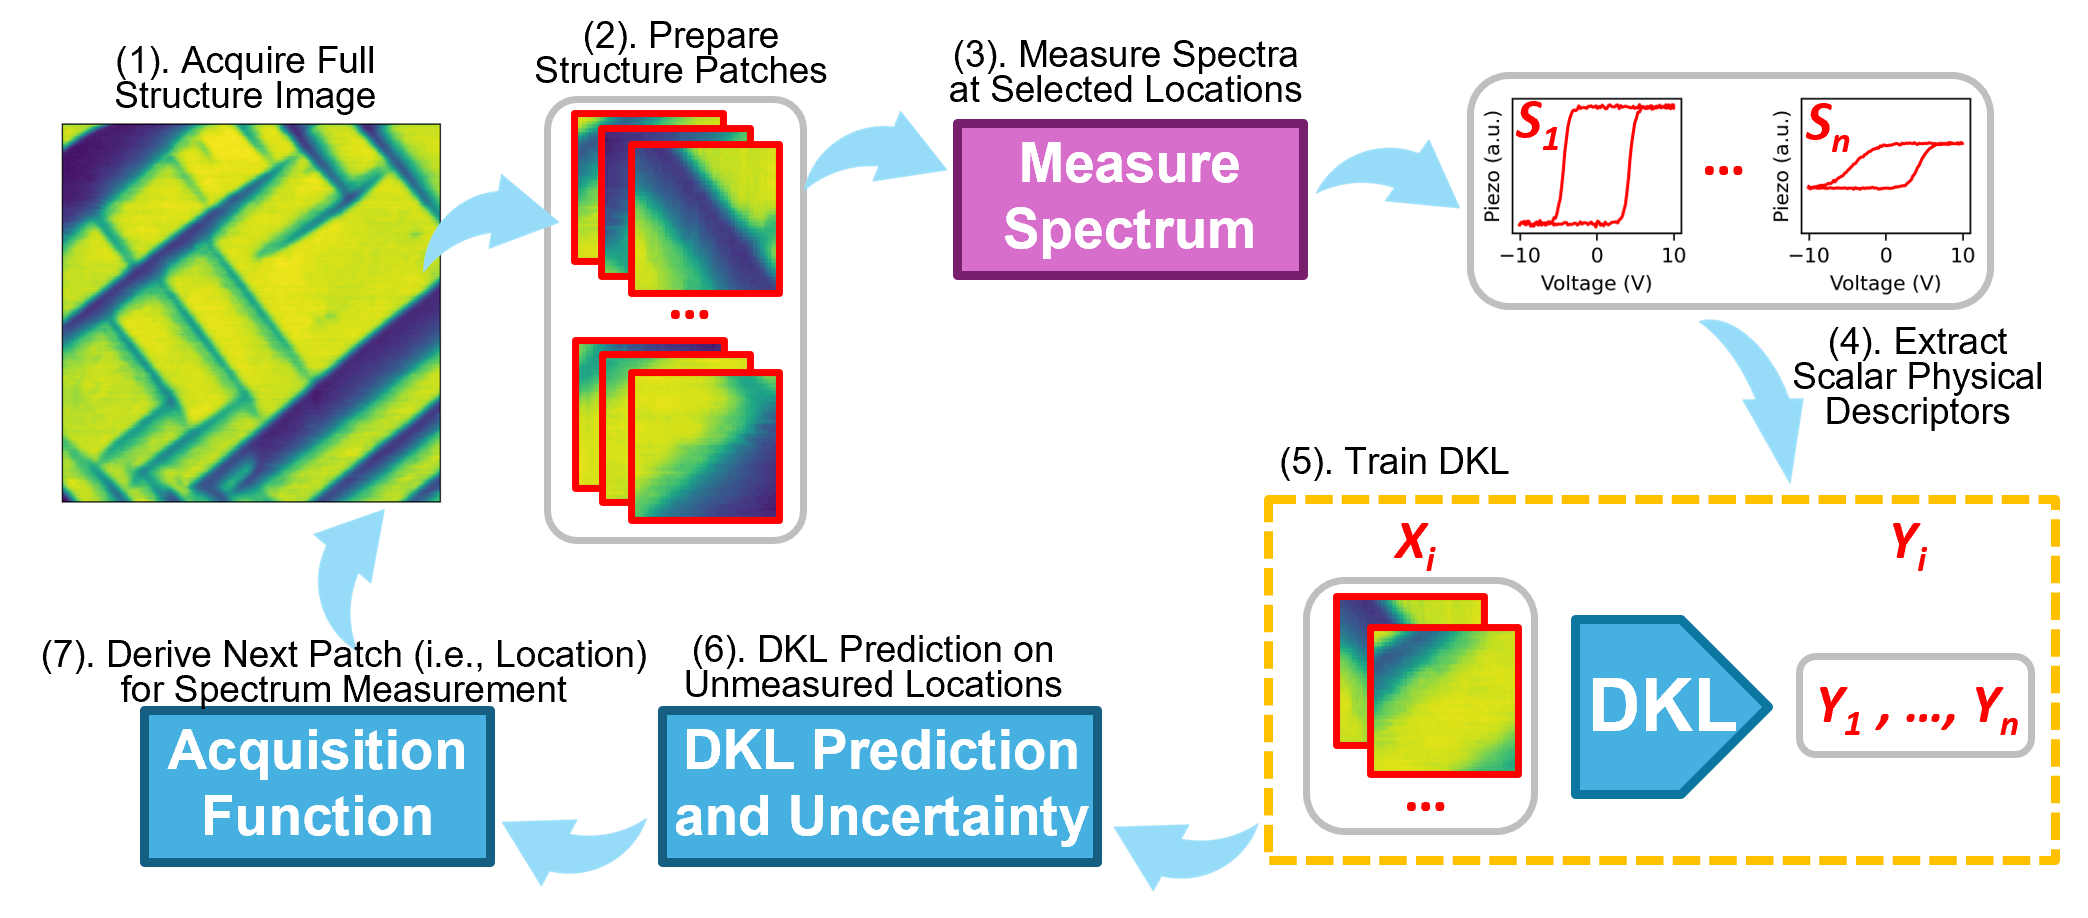

### **Application**
* DKL-driven microscopy for scientific discovery can be seen through its application in [ferroelectric polarization study](https://www.nature.com/articles/s42256-022-00460-0), [non-linear behavior investigation](https://onlinelibrary.wiley.com/doi/full/10.1002/smll.202204130), and [halide perovskites](https://pubs.acs.org/doi/full/10.1021/acs.jpclett.3c00223).

### **Further developments**
* DKL can also be combined with other ML methods such as reinforcement learning to further enhance its capability, see [example](https://www.nature.com/articles/s41524-023-00985-x)
* We also offer an example of integerating human knowledge and interest into DKL-driven autonomous experiment, see [example 1](https://arxiv.org/abs/2408.02071) and [example 2](https://arxiv.org/abs/2409.12295)

## Installation and import

In [ ]:
!pip install -q gpax
!pip install -q atomai
!pip install --upgrade gdown
!pip install pyro5
!pip install scifireaders
!pip install sidpy
!pip install pynsid
!pip install git+https://github.com/pycroscopy/DTMicroscope.git

In [3]:
#restart the session if error
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

In [2]:
from warnings import filterwarnings

import numpy as np
import matplotlib.pyplot as plt
import math
import os
import Pyro5.api
from IPython.display import clear_output, display
from sklearn.model_selection import train_test_split

import gpax
from atomai.utils import get_coord_grid, extract_patches_and_spectra, extract_subimages

gpax.utils.enable_x64()
filterwarnings("ignore", module="haiku._src.data_structures")

In [4]:
!run_server_afm

Server started and running in the background. Logs are being written to server.log.


## Load a pre-acquired PS data to simulate a microscopy experiment

Download PS data:

In [5]:
!wget -O "PTO_BEPS_1um.h5" https://www.dropbox.com/scl/fi/dwpyy2jzalcriqhza7i0c/pto_beps_1um.h5?rlkey=wg08auuxzd47fbzpx7wag5j6j&dl=1

--2025-12-11 18:46:10--  https://www.dropbox.com/scl/fi/dwpyy2jzalcriqhza7i0c/pto_beps_1um.h5?rlkey=wg08auuxzd47fbzpx7wag5j6j
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ucc885d538226c6040dd662af17f.dl.dropboxusercontent.com/cd/0/inline/C21eBlMQPMlLRjOTFsdru4HrvooXrAYULPNdW63l9V5IwJ8MxrqCb9Uw9kpsEijMp67yWTwappkLmEJFcK1MZczihCdRkLWuetq0M9j328gv0qLNmG66ipzIHnHc6NTMV54W75_yz4hpePExz8tA3mcy/file# [following]
--2025-12-11 18:46:11--  https://ucc885d538226c6040dd662af17f.dl.dropboxusercontent.com/cd/0/inline/C21eBlMQPMlLRjOTFsdru4HrvooXrAYULPNdW63l9V5IwJ8MxrqCb9Uw9kpsEijMp67yWTwappkLmEJFcK1MZczihCdRkLWuetq0M9j328gv0qLNmG66ipzIHnHc6NTMV54W75_yz4hpePExz8tA3mcy/file
Resolving ucc885d538226c6040dd662af17f.dl.dropboxusercontent.com (ucc885d538226c6040dd662af17f.dl.dropboxusercontent.com)... 162.125.65.15, 

Load the data:

In [6]:
import SciFiReaders as sr
nsid_reader = sr.NSIDReader('PTO_BEPS_1um.h5')
datasets = nsid_reader.read()

In [7]:
datasets

{'Channel_000': sidpy.Dataset of type IMAGE with:
  dask.array<array, shape=(50, 50), dtype=float64, chunksize=(50, 50), chunktype=numpy.ndarray>
  data contains: Piezoresponse (a.u.)
  and Dimensions: 
 x:  Length (um) of size (50,)
 y:  Length (um) of size (50,),
 'Channel_001': sidpy.Dataset of type POINT_CLOUD with:
  dask.array<array, shape=(2500, 256), dtype=float64, chunksize=(2500, 256), chunktype=numpy.ndarray>
  data contains: Piezoresponse (a.u.)
  and Dimensions: 
 point number:  Point number (generic) of size (2500,)
 Voltage:  Voltage (V) of size (256,)}

In [ ]:
view0 = datasets['Channel_000'].plot();

In [ ]:
view1 = datasets['Channel_001'].plot();

Plot a couple of points on top of the original image

Text(0, 0.5, 'Piezoresponse (a.u.)')

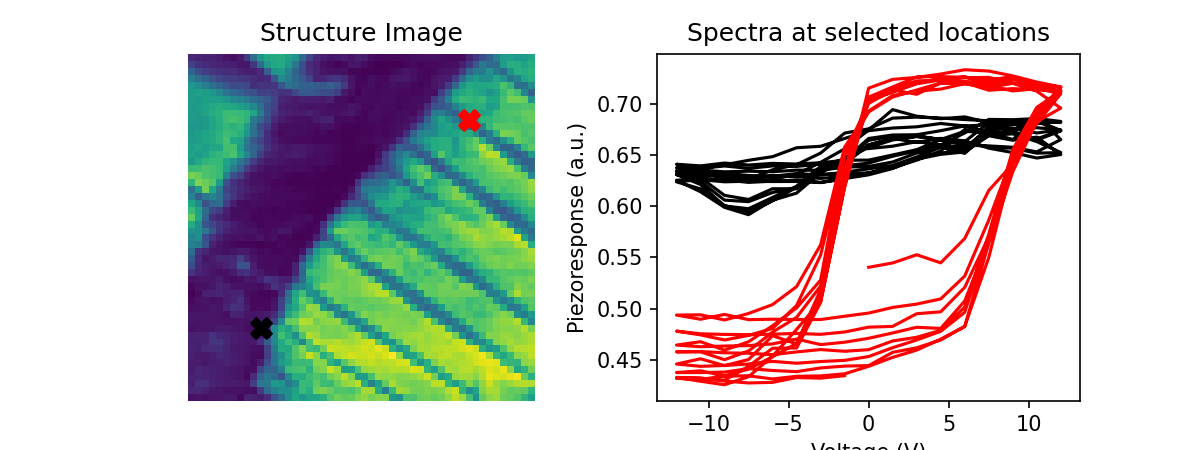

In [10]:
image = np.array(datasets['Channel_000'])
spectra = np.array(datasets['Channel_001']).reshape(50,50,-1)
v_step = datasets['Channel_001']._axes[1].values

spec_pixel_x1 = 10; spec_pixel_y1 = 10
spec_pixel_x2 = 40; spec_pixel_y2 = 40
# Plot image and spectra at selected locations
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3), dpi = 150)

ax1.imshow(image, origin = "lower")
ax1.scatter(spec_pixel_x1, spec_pixel_y1, marker='X', s=100, c='k')
ax1.scatter(spec_pixel_x2, spec_pixel_y2, marker='X', s=100, c='r')
ax1.set_title('Structure Image')
ax1.axis("off")

ax2.set_title("Spectra at selected locations")
ax2.plot(v_step, spectra[spec_pixel_x1, spec_pixel_y1], c = 'k')
ax2.plot(v_step, spectra[spec_pixel_x2, spec_pixel_y2], c = 'r')
ax2.set_xlabel('Voltage (V)')
ax2.set_ylabel('Piezoresponse (a.u.)')

⚡ ⚡ ⚡ ⚡ ⚡ ⚡ ⚡

***Note: This dataset includes an image showing nanoscale structures and spectra for all locations. However, in a real microscopy experiment, spectra are only available at the measured locations. Therefore, in the simulated experiment, DKL will only have access to the image and the spectra at the selected (i.e., measured) locations.***

## Deep Kernel Learning

✅ It will be easier to understand DKL-experiment by following the workflows of DKL-driven microscopy at the beginning of this notebook

Data preprocessing for DKL

In [11]:
# Prepare image patches that show local structures
coordinates = get_coord_grid(image, step = 1, return_dict=False)

# extract image patch for each point on a grid
window_size = 16
features_all, coords, _ = extract_subimages(image, coordinates, window_size)
features = features_all[:,:,:,0]

indices_all = np.array(coords, dtype = int)

print(features.shape)

(1225, 16, 16)


In [ ]:
#Plot an example patch and spectrum
k = 5

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), dpi =200)
ax1.imshow(image, origin = 'lower')
ax1.scatter(indices_all[k, 1], indices_all[k, 0], marker='x', s=50, c='k')

ax1.axis("off")
ax2.imshow(features[k], origin = 'lower')
ax2.axis("off")
ax3.plot(v_step, spectra[indices_all[k, 0], indices_all[k, 1]])

Normalize data:

In [13]:
norm_ = lambda x: (x - x.min()) / np.ptp(x)
features = norm_(features)

### DKL-driven microscopy experiment
Now we are going to use DKL to actively learn the relationship between local structures and their corresponding physical behavior or property, Trained DKL can make prediction for the physical property over the entire image (including unmeasured locations). We can use the prediction and uncertainty to compute acquisition function for sampling the next measurement point.

Next, we define a scalarizer function that will convert a measured spectrum into a scalar physical descriptor.

In this PS dataset, we use a scalar function that calculates the hysteresis loop area. In SNVM experiment, we need to define a different scalar function that extracts physical descriptor from SNVM spectroscopy data.

In [14]:
nsid_reader._h5_file.close()

In [15]:
#the first step here is to register the data to the microscope
uri = "PYRO:microscope.server@localhost:9092" #port for the AFM DT 9092
mic_server = Pyro5.api.Proxy(uri)
import sys

mic_server.initialize_microscope("AFM", data_path = r"PTO_BEPS_1um.h5")

mic_server.setup_microscope(data_source = 'Compound_Dataset_1')
mic_server.get_dataset_info()

[('channels', ['Channel_000', 'Channel_001']),
 ('signals', ['Piezoresponse', 'Piezoresponse']),
 ('units', ['a.u.', 'a.u.']),
 ('scans', [0]),
 ('spectra', []),
 ('point_clouds', [1])]

In [16]:
# here the scalar function is to calculate the hysteresis loop area
def loop_area (raw_spec, cycle) :
  raw_spec_len = len(raw_spec)
  cycle_len = int(raw_spec_len / cycle)
  half_len = int(cycle_len / 2)
  q_len = int(cycle_len / 4)
  loop_top, loop_bottom = [], []
  loop_top.append(raw_spec[q_len : q_len + half_len])
  loop_top.append(raw_spec[q_len + 2*half_len : q_len + 3*half_len])
  loop_top.append(raw_spec[q_len + 4*half_len : 2*q_len + 4*half_len])
  loop_bottom.append(raw_spec[:q_len])
  loop_bottom.append(raw_spec[q_len + half_len: q_len + 2*half_len])
  loop_bottom.append(raw_spec[q_len + 3*half_len: q_len + 4*half_len])
  loop_top = np.concatenate(loop_top)
  loop_bottom = np.concatenate(loop_bottom)
  return np.abs(np.sum(loop_top)-np.sum(loop_bottom))

Also define a function to plot DKL sampling results (this is optional)

In [17]:
def plot_result(indices, obj):
    plt.figure(figsize = (4, 4))
    plt.scatter(indices[:, 1], indices[:, 0], s=10, c=obj)
    next_point = indices[obj.argmax()]
    plt.scatter(next_point[1], next_point[0], s=10, marker='x', c='k')
    plt.xticks([])
    plt.yticks([])
    plt.title("Acquisition Values")
    plt.show()

define a function to convert coordinates in image to locations in microscopy measurement

In [18]:
def convert_coordinates_to_locations(coordinates=None, image_size_x = 1e-6, image_size_y = 1e-6,
                                     num_pix_x=50, num_pix_y=50):
    """
    Converts coordinates in image to probe location in microscopy.

    Args:
        coordinates (numpy.ndarray): Array representing the original coordinates in a 2D image.
        image_size_x (float): image size in x-direction.
        image_size_y (float): image size in y-direction.
        num_pix_x (int): Number of pixels in the X-direction.
        num_pix_y (int): Number of pixels in the Y-direction.

    Returns:
        numpy.ndarray: Array representing the converted parameters of locations.

    Notes:
        - The original coordinates should be a numpy array of shape [2] with the first element representing X-coordinate
            and the second element representing Y-coordinate.
    """

    original_coordinates = np.asarray(coordinates, dtype = np.float64()) # convert to int to float first

    coor_x = original_coordinates [:,0]
    coor_y = original_coordinates [:,1]

    # convert x and y
    loc_x = coor_x * image_size_x / num_pix_x
    loc_y = coor_y * image_size_y / num_pix_y

    # write converted locations
    converted_locations = np.copy(original_coordinates)
    converted_locations[:,0] = loc_x
    converted_locations[:,1] = loc_y

    return converted_locations


Set some parameters, convert data... for DKL

In [19]:
n, d1, d2 = features.shape
struc_imgs = features.reshape(n, d1*d2)
data_dim = struc_imgs.shape[-1]

struc_imgs.shape

(1225, 256)

In [20]:
#print current probe position
print(f'Current location: {mic_server.x, mic_server.y}')

Current location: (5.10204081632653e-07, 5.10204081632653e-07)


At the beginning, we need to perform spectroscopy measurements at some locations (either random or defined by operator) to start training DKL. Here let us just perform spectroscopy at some random locations.

In [21]:
#  initial measurement points
init_size = 3   # number of spectroscopy measurements at the beginning

# select the random locations and corresponding structure image, indices, etc.
(measured_struc, unmeasured_struc, indices_measured, indices_unmeasured) = train_test_split(
      struc_imgs, indices_all, test_size=1-init_size/len(struc_imgs), shuffle=True, random_state=10)

len(measured_struc)

3

In [22]:
# convert the coordinates in image to locations in microscopy measurement
locations_measured = convert_coordinates_to_locations(indices_measured)
locations_measured

array([[8.0e-07, 7.0e-07],
       [4.6e-07, 2.0e-07],
       [8.0e-07, 7.4e-07]])

In [24]:
px

np.float64(8e-07)

Now we are going to 'do' spectroscopy measurements at selected locations

Do spectroscopy at [8e-07,7e-07]
Do spectroscopy at [4.6e-07,2e-07]
Do spectroscopy at [8e-07,7.4e-07]


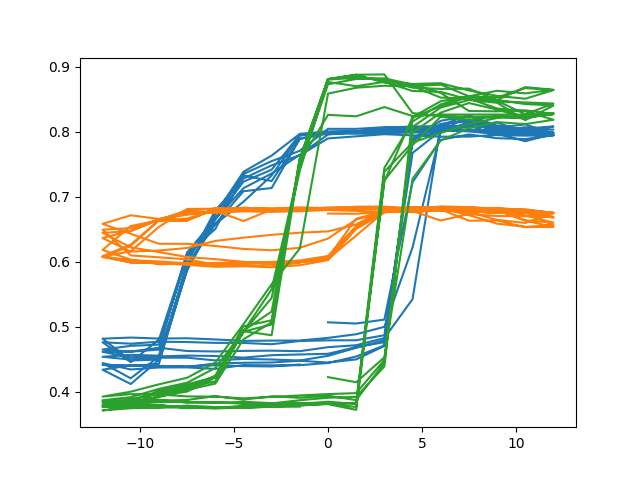

In [25]:
#############******************************************Start**********************************###############
#############***In real experiments, this part will be replaced by spepctroscopy acquistion***###############
#  initial measurement points
init_size = 3   # number of spectroscopy measurements at the beginning
measured_spec = []
measured_spec_scalar = []
#to perform spectroscopy we can use
plt.figure()
for ind in range(init_size):
  px,py = locations_measured[ind]
  mic_server.go_to(float(px), float(py))
  print ("Do spectroscopy at [{},{}]".format(px, py))
  (spec_x, shape_spec_x, dtype_spec_x), (spec_y, shape_spec_y, dtype_spec_y) = mic_server.get_spectrum()  # Do spectrum
  _spec_x = np.array(spec_x, dtype=dtype_spec_x).reshape(shape_spec_x)
  _spec_y = np.array(spec_y, dtype=dtype_spec_y).reshape(shape_spec_y)
  measured_spec.append(_spec_y)
  measuring_spec_scalar = loop_area(_spec_y, 8)               # Convert spectrum to scalar physical descriptor
  measured_spec_scalar.append(measuring_spec_scalar)

  plt.plot(_spec_x, _spec_y)
#############***************************************************************************###############
#############***************************************************************************###############


(np.float64(-0.5), np.float64(49.5), np.float64(-0.5), np.float64(49.5))

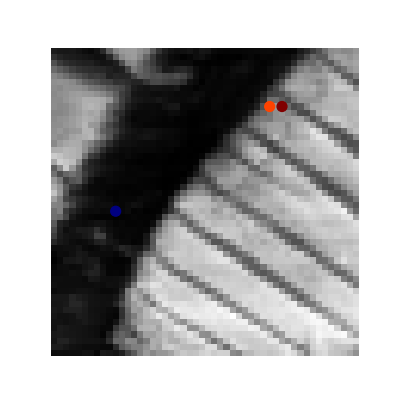

In [26]:
# we can plot the measured locations and corresponding scalar descriptor

plt.figure(figsize=(4, 4))
plt.imshow(image, origin = "lower", cmap = "gray")
plt.scatter(indices_measured[:, 1], indices_measured[:, 0], s = 50, c=measured_spec_scalar, cmap = "jet")
plt.axis("off")

Now we are going to do DKL-driven exploration

In [ ]:
exploration_steps = 50  # iterations we want to explore

key1, key2 = gpax.utils.get_keys()
for e in range(exploration_steps):
    print("{}/{}".format(e+1, exploration_steps))

    ##########----Start-DKL training, predition, and sampling-----##########
    dkl = gpax.viDKL(data_dim, 2)
    dkl.fit(key1, measured_struc, norm_(np.asarray(measured_spec_scalar)), num_steps=200, step_size=0.01)
    obj = gpax.acquisition.EI(key2, dkl, unmeasured_struc)
    # Select next point to "measure"
    next_point_idx = obj.argmax()
    # Plot sampling result
    plot_result(indices_unmeasured, obj)
    ##########-----End-DKL training, predition, and sampling-----##########


#############************************************Start Experiment*****************************###############
#############***In real experiments, this part will be replaced by spepctroscopy acquistion***###############
    # Do "measurement"
    next_loc = convert_coordinates_to_locations(indices_unmeasured[next_point_idx][None])
    px, py = next_loc[0]
    mic_server.go_to(float(px), float(py))
    print ("Do spectroscopy at [{},{}]".format(px, py))
    (spec_x, shape_spec_x, dtype_spec_x), (spec_y, shape_spec_y, dtype_spec_y) = mic_server.get_spectrum()  # Do spectrum
    _spec_x = np.array(spec_x, dtype=dtype_spec_x).reshape(shape_spec_x)
    _spec_y = np.array(spec_y, dtype=dtype_spec_y).reshape(shape_spec_y)
    measuring_spec_scalar = loop_area(_spec_y, 8)
#############***************************************************************************###############
#############***************************************************************************###############

    # Update measured/unmeasured data
    measured_struc = np.append(measured_struc, unmeasured_struc[next_point_idx][None], 0)
    unmeasured_struc = np.delete(unmeasured_struc, next_point_idx, 0)
    measured_spec_scalar = np.append(measured_spec_scalar, measuring_spec_scalar)
    indices_measured = np.append(indices_measured, indices_unmeasured[next_point_idx][None], 0)
    indices_unmeasured = np.delete(indices_unmeasured, next_point_idx, 0)

Plot DKL sampled points and corresponding physical property

([], [])

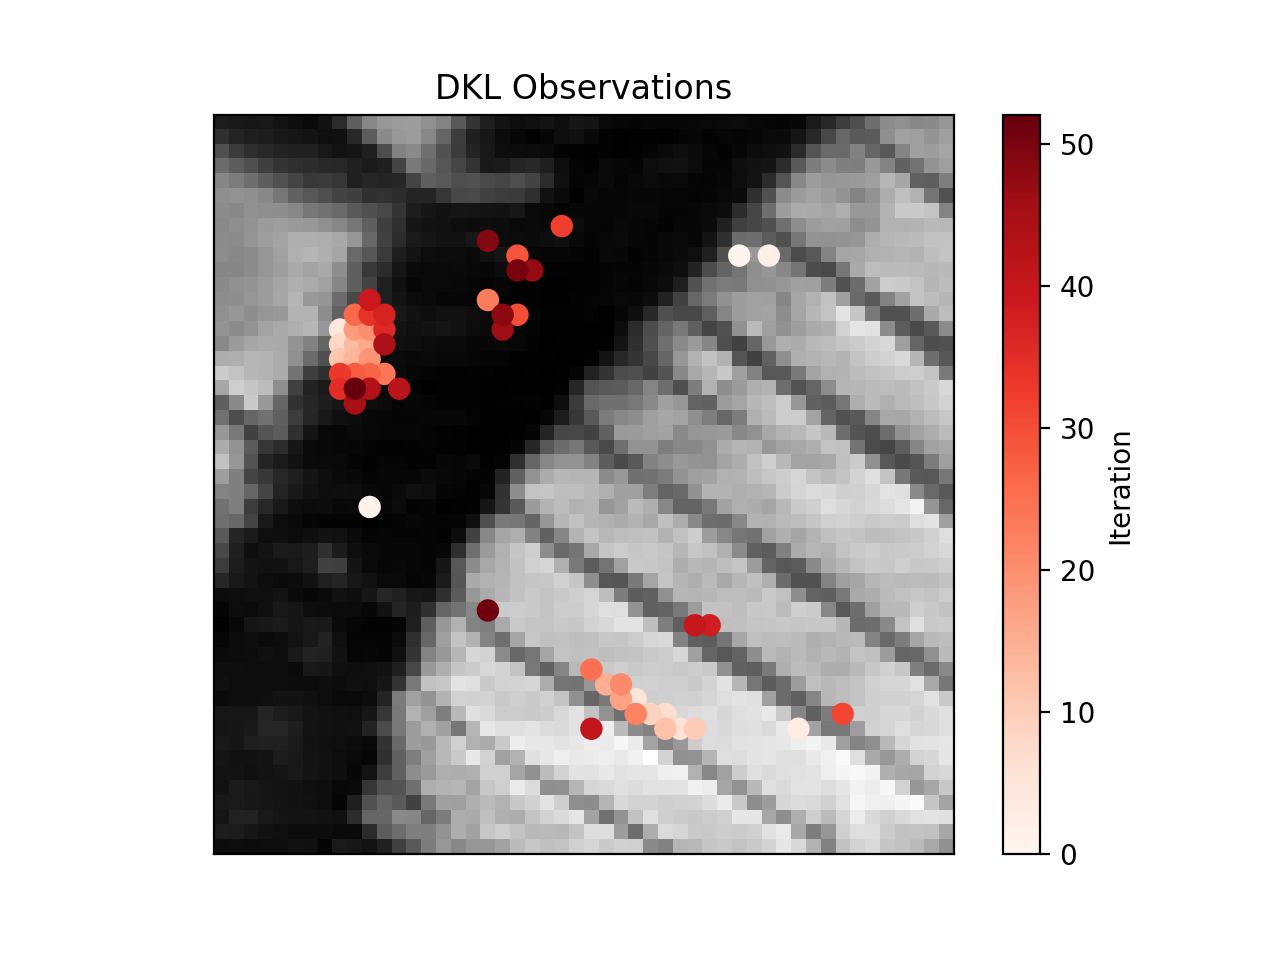

In [29]:
plt.figure(dpi = 200)
plt.imshow(image, origin="lower", cmap='gray')
plt.scatter(indices_measured[:, 1], indices_measured[:, 0],
            c=np.arange(len(indices_measured)), s=50, cmap="Reds")
plt.colorbar(label="Iteration")
plt.title("DKL Observations")
plt.xticks([])
plt.yticks([])

Trained DKL can make prediction over the entire space

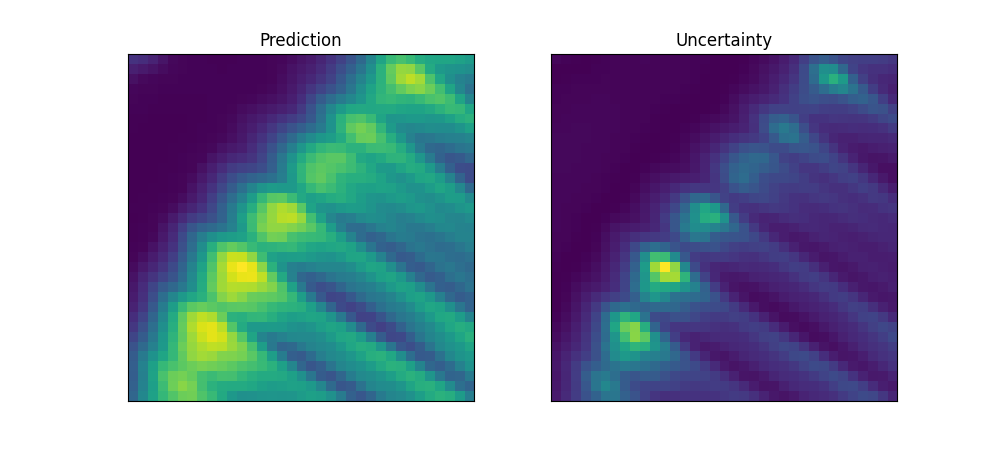

In [30]:
mean, var = dkl.predict(key2, struc_imgs)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5), dpi=100)
ax1.imshow(mean.reshape((35,35)), origin = 'lower')
ax1.set_title("Prediction")
ax2.imshow(var.reshape((35,35)), origin = 'lower')
ax2.set_title("Uncertainty")
for _ax in fig.axes:
    _ax.set_aspect('equal')
    _ax.set_xticks([])
    _ax.set_yticks([])